## Reconstruction of the diffusion signal with the kurtosis tensor model

The diffusion kurtosis model is an expansion of the diffusion tensor model. 
In addition to the diffusion tensor (DT), the
diffusion kurtosis model quantifies the degree to which water diffusion in
biological tissues is non-Gaussian using the kurtosis tensor (KT)
[Jensen2005]_.

Measurements of non-Gaussian diffusion from the diffusion kurtosis model are of
interest because they can be used to charaterize tissue microstructural
heterogeneity [Jensen2010]_ and to derive concrete biophysical parameters, such
as the density of axonal fibres and diffusion tortuosity [Fierem2011]_.
Moreover, DKI can be used to resolve crossing fibers in tractography and to
obtain invariant rotational measures not limited to well-aligned fiber
populations [NetoHe2015]_.

The diffusion kurtosis model expresses the diffusion-weighted signal as:

$S(n,b)=S_{0}e^{-bD(n)+\frac{1}{6}b^{2}D(n)^{2}K(n)}$

where $\mathbf{b}$ is the applied diffusion weighting (which is dependent on
the measurement parameters), $S_0$ is the signal in the absence of diffusion
gradient sensitization, $\mathbf{D(n)}$ is the value of diffusion along
direction $\mathbf{n}$, and $\mathbf{K(n)}$ is the value of kurtosis along
direction $\mathbf{n}$. The directional diffusion $\mathbf{D(n)}$ and kurtosis
$\mathbf{K(n)}$ can be related to the diffusion tensor (DT) and kurtosis tensor
(KT) using the following equations:

$D(n)=\sum_{i=1}^{3}\sum_{j=1}^{3}n_{i}n_{j}D_{ij}$

and

$K(n)=\frac{MD^{2}}{D(n)^{2}}\sum_{i=1}^{3}\sum_{j=1}^{3}\sum_{k=1}^{3}\sum_{l=1}^{3}n_{i}n_{j}n_{k}n_{l}W_{ijkl}$

where $D_{ij}$ are the elements of the second-order DT, and $W_{ijkl}$ the
elements of the fourth-order KT and $MD$ is the mean diffusivity. As the DT,
KT has antipodal symmetry and thus only 15 Wijkl elemments are needed to fully
characterize the KT:

$   \begin{matrix} ( & W_{xxxx} & W_{yyyy} & W_{zzzz} & W_{xxxy} & W_{xxxz}
                    & ... \\
                    & W_{xyyy} & W_{yyyz} & W_{xzzz} & W_{yzzz} & W_{xxyy}
                    & ... \\
                    & W_{xxzz} & W_{yyzz} & W_{xxyz} & W_{xyyz} & W_{xyzz}
                    & & )\end{matrix}$

In the following example we show how to fit the diffusion kurtosis model on
diffusion-weighted multi-shell datasets and how to estimate diffusion kurtosis
based statistics.

First, we import all relevant modules:

In [7]:
import numpy as np
import dipy.reconst.dki as dki
import dipy.reconst.dti as dti
import matplotlib.pyplot as plt
from dipy.data import fetch_cenir_multib
from dipy.data import read_cenir_multib
from dipy.segment.mask import median_otsu
from dipy.denoise.noise_estimate import estimate_sigma
from dipy.denoise.nlmeans import nlmeans
%matplotlib inline

DKI requires multi-shell data, i.e. data acquired from more than one non-zero
b-value. Here, we use fetch to download a multi-shell dataset with parameters
that are similar to the data collected in the Human Connectome Project (HCP).
The total size of the downloaded data is 1760 MBytes, however you only need to
fetch it once. Parameter ``with_raw`` of function ``fetch_cenir_multib`` is set
to ``False`` to only download eddy-current/motion corrected data:

In [8]:
files = fetch_cenir_multib(with_raw=False)

All files already in /Users/arokem/.dipy/cenir_multib.


Next, we read the saved dataset. To decrease the influence of diffusion signal
Taylor approximation components larger than the fourth order (componets not
taken into account by the diffusion kurtosis tensor), we only select the
b-values up to 2000 $s.mm^{-2}$:

In [9]:
bvals = [200, 400, 1000, 2000]
img, gtab = read_cenir_multib(bvals)
data = img.get_data()
affine = img.get_affine()

All files already in /Users/arokem/.dipy/cenir_multib.


Function ``read_cenir_multib`` return img and gtab which contains respectively
a nibabel Nifti1Image object (where the data can be extracted) and a
GradientTable object with information about the b-values and b-vectors.

Before fitting the data, we preform some data pre-processing. We first compute
a brain mask to avoid unnecessary calculations on the background of the image.

In [10]:
maskdata, mask = median_otsu(data, 4, 2, False, vol_idx=[0, 1], dilate=1)

Since the diffusion kurtosis models involves the estimation of a large number
of parameters [TaxCMW2015]_ and since the non-Gaussian components of the
diffusion signal are more sensitive to artefacts [NetoHe2012]_, a fundamental
data pre-processing step for diffusion kurtosis fitting is to denoise our data.
For this, we use Dipy's non-local mean filter. Note that, since the HCP-like data 
has a large number of diffusion-weigthed volumes, this procedure can take a couple 
of hours to compute the entire dataset. Therefore, to speed the run time in this example
we only denoise an axial slice of the data.

In [11]:
axial_slice = 40

sigma = estimate_sigma(data, N=4)

mask_roi = np.zeros(data.shape[:-1], dtype=bool)
mask_roi[:, :, axial_slice] = mask[:, :, axial_slice]

den = nlmeans(data, sigma=sigma, mask=mask_roi)
den = den[:, :, axial_slice, :]

Now that we have loaded and prepared the voxels to process we can go forward
with the voxel reconstruction. This can be done by first instantiating the
DiffusionKurtosisModel in the following way:

In [12]:
dkimodel = dki.DiffusionKurtosisModel(gtab)

To fit the data using the defined model object, we call the ``fit`` function of
this object:

In [13]:
dkifit = dkimodel.fit(den)

The fit method creates a DiffusionKurtosisFit object which contains all the
diffusion and kurtosis fitting parameters and other DKI attributes. For
instance, since the diffusion kurtosis model estimates the diffusion tensor,
all diffusion standard tensor statistics can be computed from the
DiffusionKurtosisFit instance. For example, we show below how to extract the
fractional anisotropy (FA), the mean diffusivity (MD), the axial diffusivity
(AD) and the radial diffusivity (RD) from the DiffusionKurtosisiFit instance.

In [14]:
FA = dkifit.fa
MD = dkifit.md
AD = dkifit.ad
RD = dkifit.rd

Note that these four standard measures could also be computed from Dipy's DTI
module. Theoretically, computing these measures from both models should be
analogous. However, since the diffusion kurtosis model involves a larger number
of parameters, diffusion statistics maps can look more noisy. On the other
hand, the diffusion statistics from the kurtosis model are expected to have
better accuracy [Veraar2011]_. For comparison purposes, we calculate below the
FA, MD, AD, and RD using Dipy's TensorModel.

In [15]:
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(den)

dti_FA = tenfit.fa
dti_MD = tenfit.md
dti_AD = tenfit.ad
dti_RD = tenfit.rd

The DT based measures can be easly visualized using matplotlib. For example,
the FA, MD, AD, and RD obtain from the diffusion kurtosis model (upper panels)
and the tensor model (lower panels) are plotted for the selected axial slice.

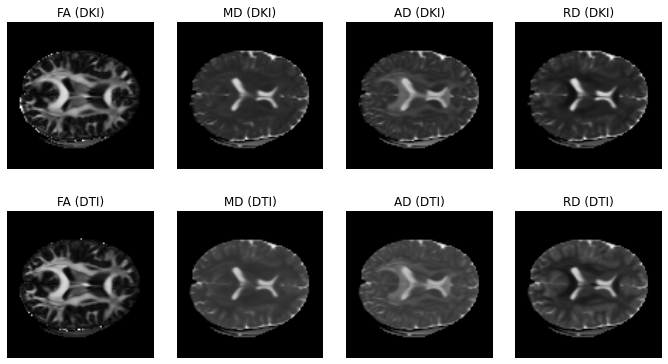

In [16]:
fig1, ax = plt.subplots(2, 4, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.3, wspace=0.05)

ax.flat[0].imshow(FA, cmap='gray')
ax.flat[0].set_title('FA (DKI)')
ax.flat[1].imshow(MD, cmap='gray')
ax.flat[1].set_title('MD (DKI)')
ax.flat[2].imshow(AD, cmap='gray')
ax.flat[2].set_title('AD (DKI)')
ax.flat[3].imshow(RD, cmap='gray')
ax.flat[3].set_title('RD (DKI)')

ax.flat[4].imshow(dti_FA, cmap='gray')
ax.flat[4].set_title('FA (DTI)')
ax.flat[5].imshow(dti_MD, cmap='gray')
ax.flat[5].set_title('MD (DTI)')
ax.flat[6].imshow(dti_AD, cmap='gray')
ax.flat[6].set_title('AD (DTI)')
ax.flat[7].imshow(dti_RD, cmap='gray')
ax.flat[7].set_title('RD (DTI)')

From the figure, we can see that the standard diffusion measures of the
HCP-like data obtained from the diffusion kurtosis model have similar contrasts
to the standard diffusion measures obtain from the tensor model. This can be
explained by the high quality of the dataset and the high performance of the
diffusion kurtosis fit procedure.

In addition to the standard diffusion statistics, the DiffusionKurtosisFit
instance can be used to estimate the non-Gaussian measures of mean kurtosis
(MK), the axial kurtosis (AK) and the radial kurtosis (RK).

In [17]:
MK = dkifit.mk(0, 3)
AK = dkifit.ak(0, 3)
RK = dkifit.rk(0, 3)

In [18]:
"""
Kurtosis measures are susceptible to high amplitude outliers. The impact of
high amplitude kurtosis outliers were removed on the above lines of codes by
introducing as an optional input the extremes of the typical values of kurtosis
(assumed here as the values on the range between 0 and 3)

Now we are ready to plot the kurtosis standard measures using matplotlib:
"""

'\nKurtosis measures are susceptible to high amplitude outliers. The impact of\nhigh amplitude kurtosis outliers were removed on the above lines of codes by\nintroducing as an optional input the extremes of the typical values of kurtosis\n(assumed here as the values on the range between 0 and 3)\n\nNow we are ready to plot the kurtosis standard measures using matplotlib:\n'

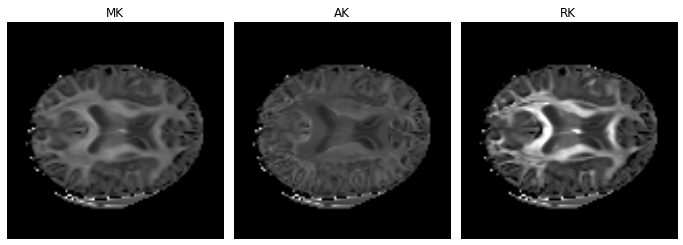

In [19]:
fig2, ax = plt.subplots(1, 3, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig2.subplots_adjust(hspace=0.3, wspace=0.05)

ax.flat[0].imshow(MK, cmap='gray')
ax.flat[0].set_title('MK')
ax.flat[1].imshow(AK, cmap='gray')
ax.flat[1].set_title('AK')
ax.flat[2].imshow(RK, cmap='gray')
ax.flat[2].set_title('RK')

The non-Gaussian behaviour of the diffusion signal is larger when water
diffusion is restrited by compartments and barriers (e.g., myelin sheath).
Therefore, as the figure above shows, white matter kurtosis values are smaller
along the axial direction of fibers (smaller amplitudes shown in the AK map)
than for the radial directions (larger amplitudes shown in the RK map).

References:

[TaxCMW2015] Tax CMW, Otte WM, Viergever MA, Dijkhuizen RM, Leemans A
             (2014). REKINDLE: Robust extraction of kurtosis INDices with
             linear estimation. Magnetic Resonance in Medicine 73(2):
             794-808.
             
[Jensen2005] Jensen JH, Helpern JA, Ramani A, Lu H, Kaczynski K (2005).
             Diffusional Kurtosis Imaging: The Quantification of
             Non_Gaussian Water Diffusion by Means of Magnetic Resonance
             Imaging. Magnetic Resonance in Medicine 53: 1432-1440

[Jensen2010] Jensen JH, Helpern JA (2010). MRI quantification of
             non-Gaussian water diffusion by kurtosis analysis. NMR in
             Biomedicine 23(7): 698-710

[Fierem2011] Fieremans E, Jensen JH, Helpern JA (2011). White matter
             characterization with diffusion kurtosis imaging. NeuroImage
             58: 177-188

[NetoHe2012] Neto Henriques R, Ferreira H, Correia M, (2012). Diffusion
             kurtosis imaging of the healthy human brain. Master
             Dissertation Bachelor and Master Programin Biomedical
             Engineering and Biophysics, Faculty of Sciences. http://repositorio.ul.pt/bitstream/10451/8511/1/ulfc104137_tm_Rafael_Henriques.pdf

[NetoHe2015] Neto Henriques R, Correia MM, Nunes RG, Ferreira HA (2015).
             Exploring the 3D geometry of the diffusion kurtosis tensor -
             Impact on the development of robust tractography procedures and
             novel biomarkers, NeuroImage 111: 85-99

[Veraar2011] Veraart J, Poot DH, Van Hecke W, Blockx I, Van der Linden A,
             Verhoye M, Sijbers J (2011). More Accurate Estimation of
             Diffusion Tensor Parameters Using Diffusion Kurtosis Imaging.
             Magnetic Resonance in Medicine 65(1): 138-145